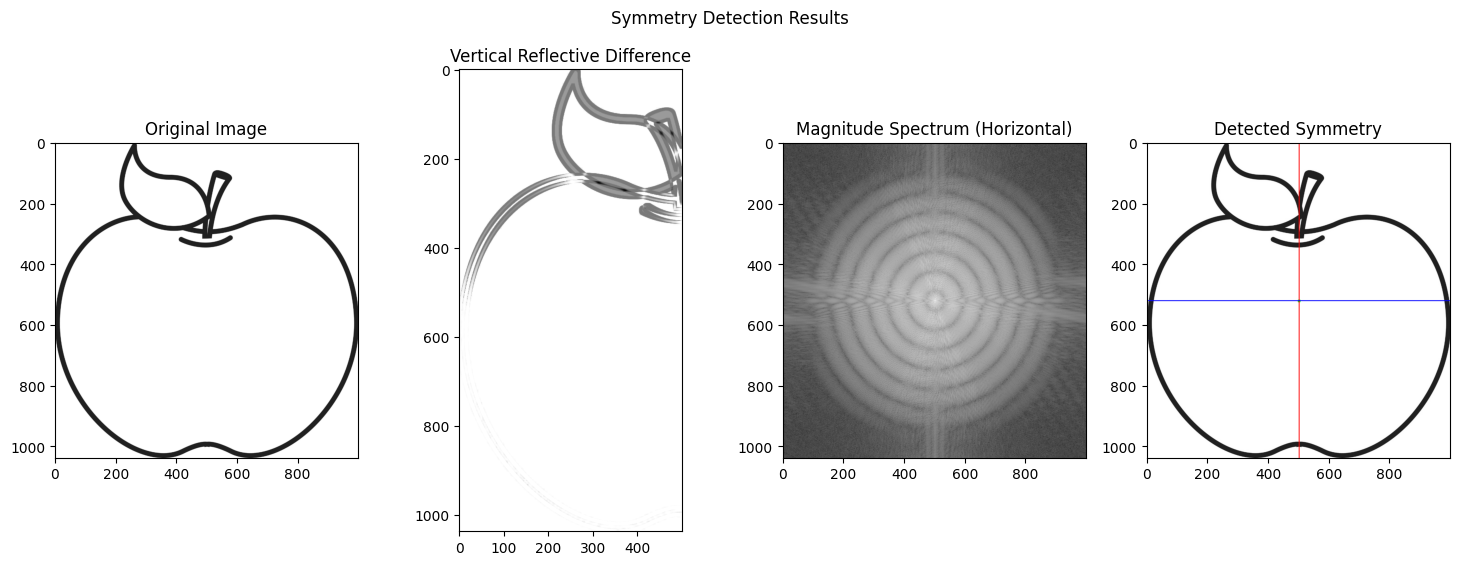

Vertical reflective symmetry score: 0.9337293668051557
Vertical reflective symmetry detected: Vertical line of symmetry
Horizontal symmetry detected: Yes
Radial symmetry center: (500, 520)


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

# Detecting vertical reflective symmetry using structural similarity score
def detect_vertical_symmetry(image):
    h, w = image.shape
    center_w = w // 2

    if w % 2 != 0:
        left_half = image[:, :center_w]
        right_half = image[:, center_w+1:]
    else:
        left_half = image[:, :center_w]
        right_half = image[:, center_w:]

    right_half_flipped = cv2.flip(right_half, 1)
    right_half_flipped = cv2.resize(right_half_flipped, (left_half.shape[1], left_half.shape[0]))

    vertical_score, vertical_diff = ssim(left_half, right_half_flipped, full=True)
    return vertical_score, vertical_diff

# Detecting horizontal symmetry using Fourier Transform
def detect_horizontal_symmetry(image):
    h, w = image.shape

    # Applying Sobel filter to detect edges
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    edges = np.sqrt(sobel_x**2 + sobel_y**2)

    # Normalizing the edges for better visualization
    edges = cv2.normalize(edges, None, 0, 255, cv2.NORM_MINMAX)
    edges = np.uint8(edges)

    # Computing Fourier Transform
    f_transform = np.fft.fft2(edges)
    f_transform_shifted = np.fft.fftshift(f_transform)

    # Taking the magnitude spectrum (log scale)
    magnitude_spectrum = np.log(np.abs(f_transform_shifted) + 1)

    # Summation of the magnitude spectrum along horizontal axis
    horizontal_symmetry_score = np.sum(magnitude_spectrum[int(h/2)-1:int(h/2)+1, :], axis=0)

    horizontal_symmetry_score = horizontal_symmetry_score / np.max(horizontal_symmetry_score)
    threshold = 0.8
    is_horizontal_symmetry = np.any(horizontal_symmetry_score > threshold)

    return is_horizontal_symmetry, edges, magnitude_spectrum, horizontal_symmetry_score

def detect_radial_symmetry(image):
    moments = cv2.moments(image)
    if moments["m00"] != 0:
        cX = int(moments["m10"] / moments["m00"])
        cY = int(moments["m01"] / moments["m00"])
    else:
        cX, cY = image.shape[1] // 2, image.shape[0] // 2

    edges = cv2.Canny(image, 50, 150)

    radial_score = 0
    num_points = 0
    for angle in range(0, 360, 5):
        rad = np.deg2rad(angle)
        for r in range(1, min(cX, cY)):
            x = int(cX + r * np.cos(rad))
            y = int(cY + r * np.sin(rad))
            if 0 <= x < image.shape[1] and 0 <= y < image.shape[0]:
                radial_score += edges[y, x]
                num_points += 1

    radial_symmetry = radial_score / num_points > 0.1
    return radial_symmetry, (cX, cY), edges

def plot_symmetry(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if image is None:
        print("Error loading image")
        return

    vertical_score, vertical_diff = detect_vertical_symmetry(image)
    vertical_symmetry = vertical_score > 0.8

    horizontal_symmetry, edges, magnitude_spectrum, horizontal_symmetry_score = detect_horizontal_symmetry(image)

    radial_symmetry, center, edges = detect_radial_symmetry(image)

    result_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    if radial_symmetry:
        cv2.circle(result_image, center, 5, (0, 255, 0), -1)
    if vertical_symmetry:
        cv2.line(result_image, (image.shape[1] // 2, 0), (image.shape[1] // 2, image.shape[0]), (255, 0, 0), 2)
    if horizontal_symmetry:
        cv2.line(result_image, (0, image.shape[0] // 2), (image.shape[1], image.shape[0] // 2), (0, 0, 255), 2)

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 4, 1)
    plt.title('Original Image')
    plt.imshow(image, cmap='gray')

    plt.subplot(1, 4, 2)
    plt.title('Vertical Reflective Difference')
    plt.imshow(vertical_diff, cmap='gray')

    plt.subplot(1, 4, 3)
    plt.title('Magnitude Spectrum (Horizontal)')
    plt.imshow(magnitude_spectrum, cmap='gray')

    plt.subplot(1, 4, 4)
    plt.title('Detected Symmetry')
    plt.imshow(result_image)

    plt.suptitle('Symmetry Detection Results')
    plt.show()

    print(f"Vertical reflective symmetry score: {vertical_score}")
    if vertical_symmetry:
        print("Vertical reflective symmetry detected: Vertical line of symmetry")
    else:
        print("No vertical reflective symmetry detected")

    print(f"Horizontal symmetry detected: {'Yes' if horizontal_symmetry else 'No'}")
    print(f"Radial symmetry center: {center}" if radial_symmetry else "No radial symmetry detected")

image_path = '/content/apple.png'  # Change this to the path of your image

plot_symmetry(image_path)
